In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
## pip install git+https://github.com/isaranto/omega_index.git
import omega_index
import powerlaw

import sys
sys.path.append('../')
from CAS import *


## ABCD-o graphs

* ground-truth saved in 'gt' vertex attribute


In [2]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        

In [3]:
## utility function - we fix all the parameters in the experiments below and only vary xi
def build_ABCDo(xi, num_nodes=10000):
    params = ABCDParams(
        vcount=num_nodes, 
        gamma=2.5,
        min_degree=10,
        max_degree=int(num_nodes**.5),
        beta=1.5,
        min_community_size=50,
        max_community_size=int(num_nodes**.767),
        xi=xi,
        num_outliers=250,
    )    
    G = ABCDGraph(params)
    G.build()
    g = G.exporter.to_igraph()
    g.vs['gt'] = np.array(g.vs['ground_truth_community'])+1 ## outliers have community 0 instead of -1
    return g

## given a list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L


# Simple EDA

In [4]:
%%time
G = build_ABCDo(xi = .1, num_nodes=1000000)


CPU times: user 3min 33s, sys: 7.92 s, total: 3min 41s
Wall time: 3min 42s


In [5]:
## degree distribution
deg = G.degree()
print('min degree',min(deg),'max degree',max(deg))
X = powerlaw.Fit(deg, xmin = min(deg), verbose=False)
print("Value of gamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


min degree 10 max degree 1001
Value of gamma: 2.630107174945691
l': 10.0
KS statistic: 0.01725390429836937


In [6]:
## community size distribution
C = [len(y) for y in mems2comms([[x] for x in G.vs['gt']])]
print('min comm',min(C),'max comm',max(C))
X = powerlaw.Fit(C, xmin=min(C), verbose=False)
print("Value of gamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


min comm 50 max comm 38833
Value of gamma: 1.5674740540268635
l': 50.0
KS statistic: 0.04250047925345432


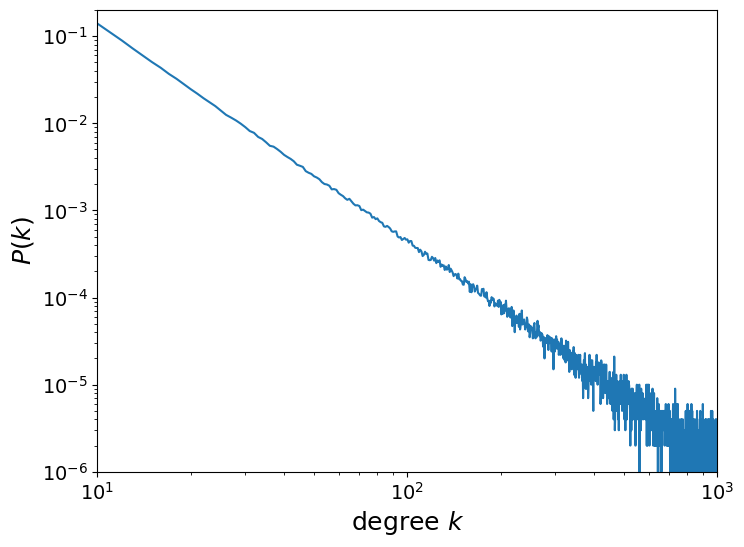

In [7]:
deg_distri=Counter(deg)

x=[]
y=[]
for i in sorted(deg_distri):   
    x.append(i)
    y.append(deg_distri[i]/G.vcount())

plt.figure(figsize=(8,6))    
plt.plot(x,y)

plt.xlabel('degree $k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale('log')
plt.xscale('log')
plt.axis([min(deg),max(deg),0.000001,0.2])
plt.show()

## For the WAW paper

In [8]:
G = ig.Graph()

In [9]:
XIs = [.35,.50,.60,.65,.70]
num_out = 250
for i in range(len(XIs)):
    G[i] = build_ABCDo(XIs[i])

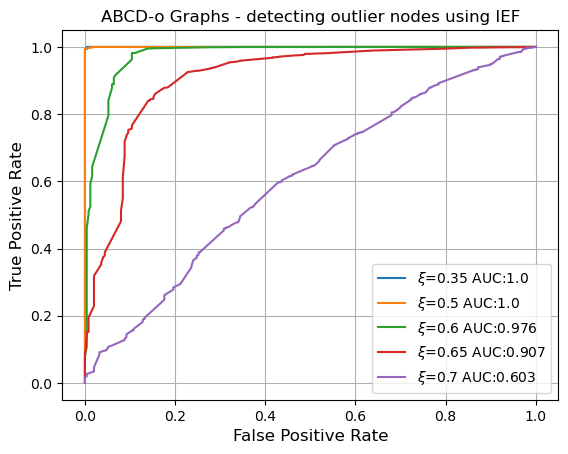

In [10]:
for i in range(len(XIs)):
    xi = XIs[i]
    g = G[i]
    num_nodes = g.vcount()
    A = g.get_adjacency_sparse()
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
    g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
    g.vs['C'] = C.max(axis=1).toarray().flatten()
    g.vs['P'] = P.max(axis=1).toarray().flatten()
    y = [int(x>0) for x in g.vs['gt']]

    fpr, tpr, thresholds = roc_curve(y, g.vs['IEF'], pos_label=1)
    auc = AUC(y, g.vs['IEF'])
    plt.plot(fpr, tpr, label=r'$\xi$='+str(xi)+' AUC:'+str(round(auc,3)))
plt.legend()
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.grid()
plt.title(r'ABCD-o Graphs - detecting outlier nodes using IEF');
plt.savefig('abcdo_ief.png');


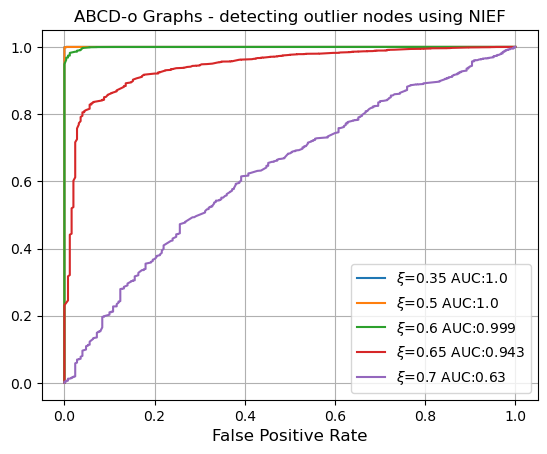

In [11]:
for i in range(len(XIs)):
    xi = XIs[i]
    g = G[i]
    num_nodes = g.vcount()
    A = g.get_adjacency_sparse()
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
    g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
    g.vs['C'] = C.max(axis=1).toarray().flatten()
    g.vs['P'] = P.max(axis=1).toarray().flatten()
    y = [int(x>0) for x in g.vs['gt']]

    fpr, tpr, thresholds = roc_curve(y, g.vs['beta'], pos_label=1)
    auc = AUC(y, g.vs['beta'])
    plt.plot(fpr, tpr, label=r'$\xi$='+str(xi)+' AUC:'+str(round(auc,3)))
plt.legend()
plt.xlabel('False Positive Rate', fontsize=12)
#plt.ylabel('True Positive Rate', fontsize=12)
plt.grid()
plt.title(r'ABCD-o Graphs - detecting outlier nodes using NIEF');
plt.savefig('abcdo_nief.png');


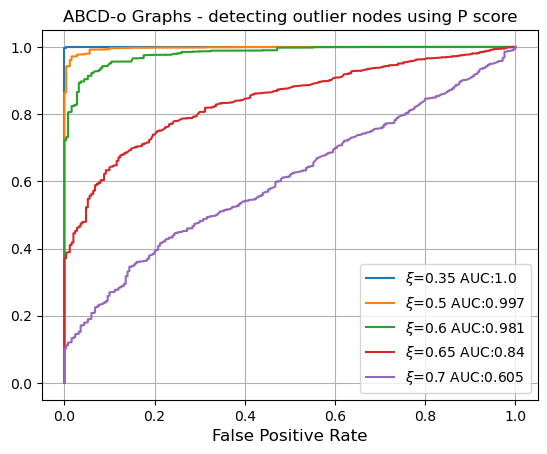

In [12]:
for i in range(len(XIs)):
    xi = XIs[i]
    g = G[i]
    num_nodes = g.vcount()
    A = g.get_adjacency_sparse()
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
    g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
    g.vs['C'] = C.max(axis=1).toarray().flatten()
    g.vs['P'] = P.max(axis=1).toarray().flatten()
    y = [int(x>0) for x in g.vs['gt']]

    fpr, tpr, thresholds = roc_curve(y, g.vs['P'], pos_label=1)
    auc = AUC(y, g.vs['P'])
    plt.plot(fpr, tpr, label=r'$\xi$='+str(xi)+' AUC:'+str(round(auc,3)))
plt.legend()
plt.xlabel('False Positive Rate', fontsize=12)
#plt.ylabel('True Positive Rate', fontsize=12)
plt.grid()
plt.title(r'ABCD-o Graphs - detecting outlier nodes using P score');
plt.savefig('abcdo_p.png');


## Investigating the bend with IEF


In [13]:
xi = 0.6
g = build_ABCDo(xi)
num_nodes = g.vcount()
A = g.get_adjacency_sparse()
g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
L = []

## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
g.vs['C'] = C.max(axis=1).toarray().flatten()
g.vs['P'] = P.max(axis=1).toarray().flatten()

## rank w.r.t. top score, AMI w.r.t. original partition
r_ief = np.argsort(g.vs['IEF'])
for k in range(num_nodes//10):
    L.append([xi, 'IEF', k, AMI( np.array(g.vs['leiden'])[r_ief[k:]] , np.array(g.vs['gt'])[r_ief[k:]] )])        
r_beta = np.argsort(g.vs['beta'])
for k in range(num_nodes//10):
    L.append([xi, 'beta', k, AMI( np.array(g.vs['leiden'])[r_beta[k:]] , np.array(g.vs['gt'])[r_beta[k:]] )])        


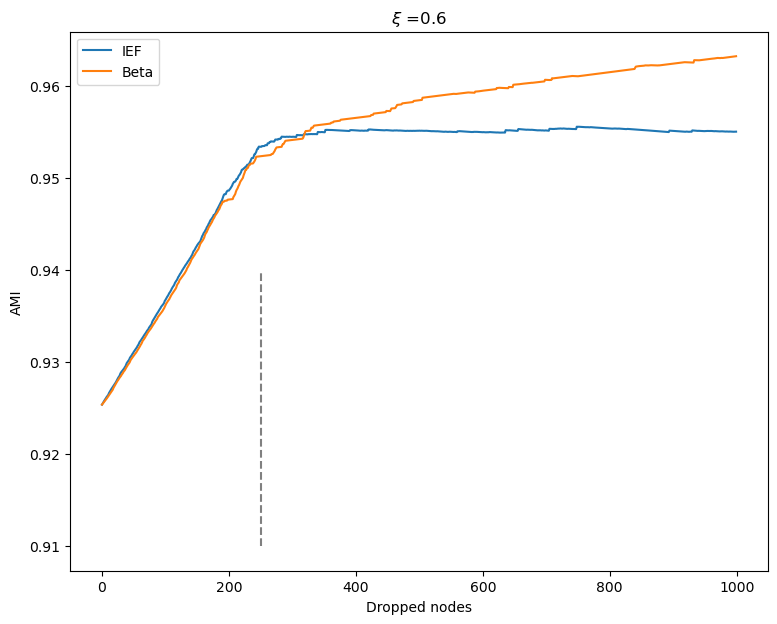

In [14]:
plt.figure(figsize=(9,7))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 

D = df
D = D.groupby(by=['dropped','algo'])['ami'].mean()
plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
plt.legend()
plt.xlabel('Dropped nodes')
plt.ylabel('AMI')
#plt.vlines(250,.91,.94,linestyles='dashed',colors='grey')
plt.title(r'$\xi$ ='+str(xi));


From the results below, the nodes filtered out with Beta only in positions 250:1000 belong to the largest communities,
which is not the case with the ones filtered by IEF only.

The fact that Beta yields better AMI from that point on indicates that this correction is useful in retaining the stronger signal.


In [15]:
in_both = set(r_ief[250:1000]).intersection(set(r_beta[250:1000]))
in_ief = set(r_ief[250:1000]).difference(set(r_beta[250:1000]))
in_beta = set(r_beta[250:1000]).difference(set(r_ief[250:1000]))


In [16]:
Counter([g.vs[i]['leiden'] for i in in_beta]).most_common(5)


[(2, 496), (0, 59), (7, 40), (5, 5), (24, 4)]

In [17]:
Counter([g.vs[i]['leiden'] for i in in_ief]).most_common(5)


[(6, 40), (16, 37), (5, 37), (4, 35), (2, 34)]

In [18]:
Counter(g.vs['leiden']).most_common(5)


[(2, 1730), (0, 971), (7, 965), (5, 608), (12, 483)]

## Comparing Pv and Beta

Where they differ, Beta picks larger communities.

So what happens is that:
* IEF does not correct for community size, so it naturally favours membership to large communities
* Beta adds a bias to tradeoff between community sizes, thus also allowing membership to smaller communities
* Pv biases even more toward smaller communities.


In [19]:
xi = 0.6
g = build_ABCDo(xi)
num_nodes = g.vcount()
A = g.get_adjacency_sparse()
g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
L = []

## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))


In [20]:
g.vs['IEF'] = np.array(IEF.argmax(axis=1)).flatten()
g.vs['beta'] = np.array(Beta.argmax(axis=1)).flatten()
g.vs['C'] = np.array(C.argmax(axis=1)).flatten()
g.vs['P'] = np.array(P.argmax(axis=1)).flatten()


In [21]:
g.vs[0]

igraph.Vertex(<igraph.Graph object at 0x106497550>, 0, {'ground_truth_community': 0, 'gt': 1, 'leiden': 0, 'IEF': 0, 'beta': 0, 'C': 0, 'P': 0})

In [22]:
V = [v for v in g.vs if v['beta']!=v['P']]
Counter([v['beta'] for v in V])

Counter({0: 148, 2: 59, 1: 25, 4: 10, 8: 5, 9: 5, 6: 3, 13: 2, 3: 1})

In [23]:
Counter([v['P'] for v in V])

Counter({22: 22,
         23: 18,
         20: 17,
         18: 17,
         13: 16,
         17: 15,
         10: 14,
         6: 14,
         19: 14,
         21: 13,
         16: 12,
         11: 12,
         8: 10,
         14: 10,
         3: 10,
         7: 10,
         5: 10,
         9: 9,
         15: 7,
         12: 4,
         4: 2,
         1: 2})

In [24]:
Counter(g.vs['leiden']).most_common(5)

[(0, 1982), (2, 1479), (1, 1146), (4, 765), (8, 626)]

# Experiments

## (1) AMI vs dropped nodes, ABCD-o

* (1a) use different scores to rank the nodes (w.r.t. outlyingness), but final score w.r.t. Leiden partition
* (1b) actually use the scores for ranking AND scoring


In [25]:
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65]


In [32]:
## Scores - only dropping 'outliers'
REP = 10
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    print(xi)
    for rep in range(REP):
        random.seed(rep)
        np.random.seed(rep)
        g = build_ABCDo(xi)
        num_nodes = g.vcount()
        A = g.get_adjacency_sparse()
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership

        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

fn = 'abcdo_AMI_leiden.pkl'
with open(fn,'wb') as fp:
    pickle.dump(L,fp)

0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


In [33]:
fn = 'abcdo_AMI_leiden.pkl'
with open(fn,'rb') as fp:
    L = pickle.load(fp)

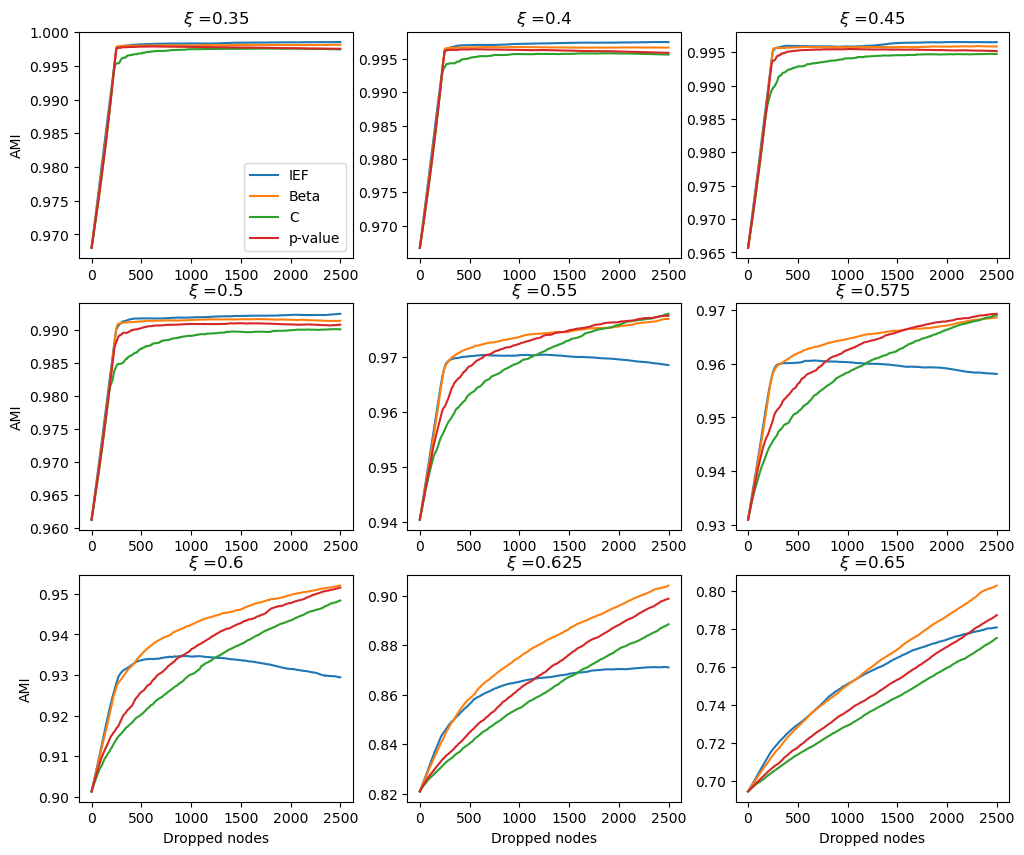

In [34]:

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
#plt.savefig('abcdo_AMI_leiden.png');


In [35]:
## Scores - using those
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    print(xi)
    for rep in range(REP):
#         random.seed(rep)
#         np.random.seed(rep)
        g = build_ABCDo(xi)
        num_nodes = g.vcount()
        A = g.get_adjacency_sparse()
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership

        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['IEF_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['beta_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['C_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()
        g.vs['P_top'] = np.array(IEF.argmax(axis=1)).flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['IEF_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['beta_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['C_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['P_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
fn = 'abcdo_AMI_scores.pkl'
with open(fn,'wb') as fp:
    pickle.dump(L,fp)
    

0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


In [36]:
fn = 'abcdo_AMI_scores.pkl'
with open(fn,'rb') as fp:
    L = pickle.load(fp)

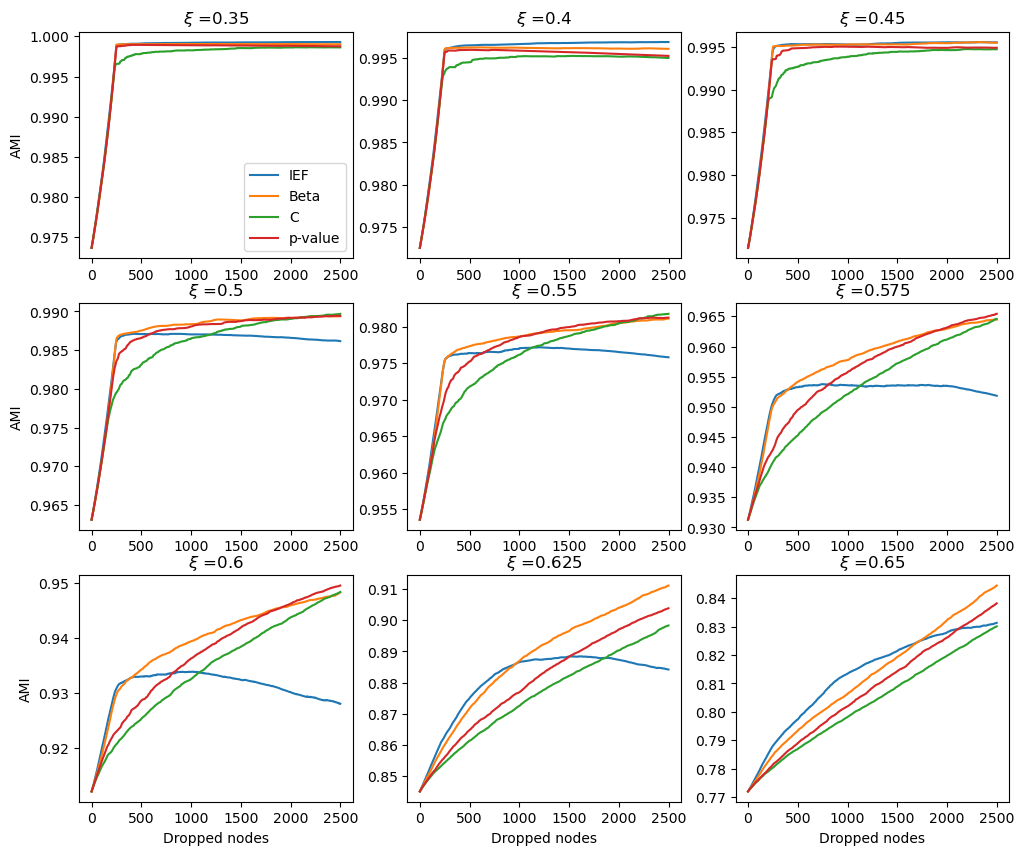

In [37]:

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
#plt.savefig('abcdo_AMI_scores.png');


## Omega index

In [ ]:
%%time
L = []
for xi in XIs:
    g = build_ABCDo(xi)
    gt = sparse2dict(partition2sparse(g.vs['gt']))
    del gt[0] ## drop outliers
    IEF, Beta, C, P, DegPart = CAS(g.get_adjacency_sparse(), 
                                partition2sparse(g.community_leiden(objective_function='modularity').membership))
    for th in np.arange(10,81,5)/100:
        print(xi, th)
        M = score_to_memberships(Beta, DegPart, threshold=th)
        score = omega_index.Omega(gt, sparse2dict(M)).omega_score
        ctr = Counter(np.array(M.sum(axis=1)).flatten())
        L.append(['Beta', xi, th, ctr[0], ctr[1], 10000-ctr[0]-ctr[1], score])    
        M = score_to_memberships(IEF, DegPart, threshold=th)
        score = omega_index.Omega(gt, sparse2dict(M)).omega_score
        ctr = Counter(np.array(M.sum(axis=1)).flatten())
        L.append(['IEF', xi, th, ctr[0], ctr[1], 10000-ctr[0]-ctr[1], score])


0.35 0.1


In [ ]:
fn = 'omega.pkl'
with open(fn,'wb') as fp:
    pickle.dump(L,fp)


In [ ]:
fn = 'omega.pkl'
with open(fn,'rb') as fp:
    L = pickle.load(fp)

In [ ]:
df = pd.DataFrame(L, columns=['algo','xi', 'threshold','0','1','2+','Omega'])

plt.figure(figsize=(12,10))
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    plt.plot(df[ (df.xi==xi) & (df.algo=='Beta') ]['threshold'],
             df[ (df.xi==xi) & (df.algo=='Beta') ]['Omega'], label='Beta', color='red');
    plt.plot(df[ (df.xi==xi) & (df.algo=='IEF')]['threshold'],
             df[ (df.xi==xi) & (df.algo=='IEF')]['Omega'], label='IEF', color='blue');
plt.legend();


# ICI!

### (2) Classify outliers - ROC curves

In [ ]:
plt.figure(figsize=(12,10))

for i in range(len(XIs)): 
    xi = XIs[i]
    print(xi)
    g = build_ABCDo(xi)
    A = g.get_adjacency_sparse()
    ## Leiden:
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    plt.subplot(3,3,i+1)

    y = [int(x>0) for x in g.vs['gt']]

    g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['IEF'], pos_label=1)
    auc = AUC(y, g.vs['IEF'])
    plt.plot(fpr, tpr, label='IEF: '+str(round(auc,3)))

    g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['beta'], pos_label=1)
    auc = AUC(y, g.vs['beta'])
    plt.plot(fpr, tpr, label='Beta: '+str(round(auc,3)))

    g.vs['C'] = C.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['C'], pos_label=1)
    auc = AUC(y, g.vs['C'])
    plt.plot(fpr, tpr, label='C: '+str(round(auc,3)))

    g.vs['P'] = P.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['P'], pos_label=1)
    auc = AUC(y, g.vs['P'])
    plt.plot(fpr, tpr, label='p-value: '+str(round(auc,3)))

    plt.legend(title='AUC')
    if i>5:
        plt.xlabel('FPR')
    if i%3==0:
        plt.ylabel('TPR');
    plt.legend()
    plt.title(r'ROC for $\xi$ ='+str(xi))  
#plt.savefig('abcdo_ROC_scores.png')    


### (3) Scores, varying threshold

In [ ]:
%%time

range_IEF = np.arange(.05,.501,.025)
range_beta = np.arange(.05,.501,.025)
range_C = np.arange(1,8.001,.25)
range_P = np.arange(.90,1,.0025)

L = []
for xi in XIs:
    print(xi)
    g = build_ABCDo(xi)
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    A = g.get_adjacency_sparse()
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    for th in range_IEF:
        M = score_to_memberships(IEF, DegPart, th)
        L.append(['IEF', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_beta:
        M = score_to_memberships(Beta, DegPart, th)
        L.append(['Beta', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_C:
        M = score_to_memberships(C, DegPart, th)
        L.append(['C', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_P:
        M = score_to_memberships(P, DegPart, th)
        L.append(['P', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])

df = pd.DataFrame(L, columns=['score','xi','threshold','outliers','TP'])
df['FP'] = df['outliers'] - df['TP']


In [ ]:
num_out = 250
df['sum'] = df['FP'] + df['TP']

In [ ]:
_df = df[df.score == 'IEF']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdo_TP_FP_IEF.png');    


In [ ]:
for xi in XIs:
    plt.semilogy(_df[_df.xi == xi]['threshold'] , _df[_df.xi == xi]['sum'], label=xi)
plt.xlabel('IEF threshold')
plt.ylabel('Number below threshold')    
plt.hlines(250,min(_df.threshold),max(_df.threshold), linestyles='dotted', color='black')
plt.legend(title=r'$\xi$')
#plt.savefig('abcdo_sum_IEF.png');    


In [ ]:
_df = df[df.score == 'Beta']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdo_TP_FP_Beta.png');    


In [ ]:
for xi in XIs:
    plt.semilogy(_df[_df.xi == xi]['threshold'] , _df[_df.xi == xi]['sum'], label=xi)
plt.xlabel('Beta threshold')
plt.ylabel('Number below threshold')    
plt.hlines(250,min(_df.threshold),max(_df.threshold), linestyles='dotted', color='black')
plt.legend(title=r'$\xi$')
#plt.savefig('abcdo_sum_Beta.png');    


In [ ]:
_df = df[df.score == 'C']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdo_TP_FP_C.png');    


In [ ]:
for xi in XIs:
    plt.semilogy(_df[_df.xi == xi]['threshold'] , _df[_df.xi == xi]['sum'], label=xi)
plt.xlabel('C threshold')
plt.ylabel('Number below threshold')    
plt.hlines(250,min(_df.threshold),max(_df.threshold), linestyles='dotted', color='black')
plt.legend(title=r'$\xi$')
#plt.savefig('abcdo_sum_C.png');    


In [ ]:
_df = df[df.score == 'P']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdo_TP_FP_P.png');    


In [ ]:
for xi in XIs:
    plt.semilogy(_df[_df.xi == xi]['threshold'] , _df[_df.xi == xi]['sum'], label=xi)
plt.xlabel('P-score threshold')
plt.ylabel('Number below threshold')    
plt.hlines(250,min(_df.threshold),max(_df.threshold), linestyles='dotted', color='black')
plt.legend(title=r'$\xi$')
#plt.savefig('abcdo_sum_P.png');    
